In [1]:
from fastai.text import *
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
from sklearn.utils import class_weight
from src.utils import plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
%load_ext autoreload
%autoreload 2

In [2]:
yhat = pd.read_csv('/contents/output/csv/predictions_v2.csv', sep='|')

In [4]:
test_label = yhat['pred_sentiment']

(-1.434316588670069,
 1.4294809816802316,
 -1.1135250973512694,
 1.0953819161734075)

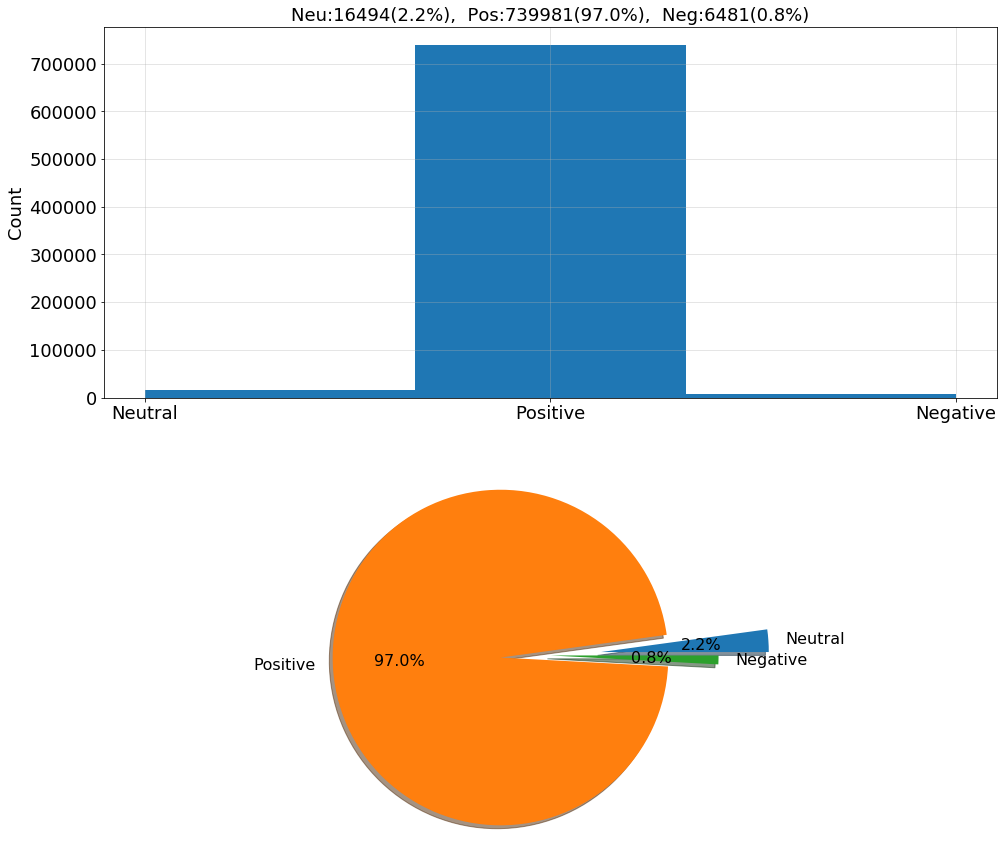

In [5]:
lcs = np.array([len(test_label[test_label==i]) for i in range(3)])
lcp = np.array(lcs)/len(test_label)*100

f, ax = plt.subplots(2,1,figsize=(16,15))
ax[0].hist(test_label,bins=3)
ax[0].grid(alpha=0.5)
ax[0].set_title('Neu:%i(%0.1f%%),  Pos:%i(%0.1f%%),  Neg:%i(%0.1f%%)'\
                %(lcs[0],lcp[0],lcs[1],lcp[1],lcs[2],lcp[2]), fontsize=18)
ax[0].grid(alpha=0.4)
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels(['Neutral', 'Positive', 'Negative'], fontsize=18)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize=18)
ax[0].tick_params(axis='both', labelsize=18)
labels = ['Neutral', 'Positive', 'Negative']
sizes = lcp
explode = (0.3, 0.3, 0)
ax[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True,\
       textprops={'fontsize':16})
ax[1].axis('equal')

In [9]:
neu = yhat['0_prob']
pos = yhat['1_prob']
neg = yhat['2_prob']

In [10]:
dups_i = yhat.text.duplicated() 
yhat_no_dup = yhat[~dups_i]

In [11]:
test_label_no_dup = yhat_no_dup['pred_sentiment']

(-1.4351447194370575,
 1.4276724548185906,
 -1.1224045866095909,
 1.0896224980661553)

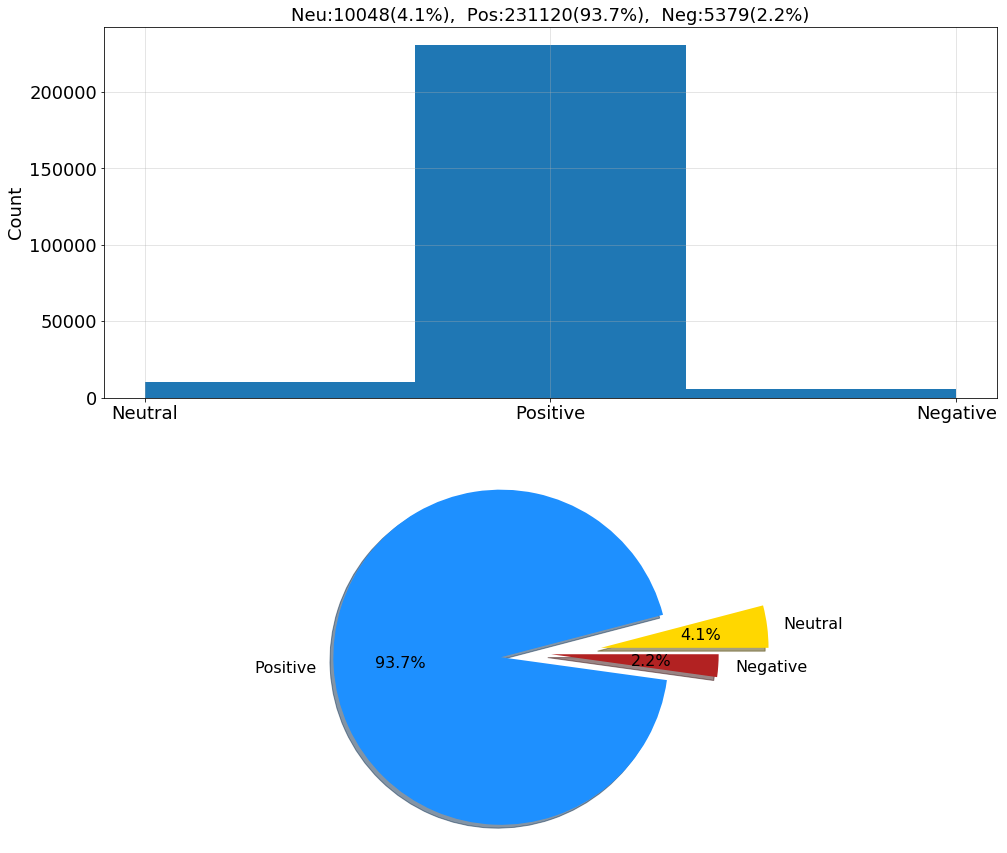

In [12]:
nd_lcs = np.array([len(test_label_no_dup[test_label_no_dup==i]) for i in range(3)])
nd_lcp = np.array(nd_lcs)/len(test_label_no_dup)*100

f, ax = plt.subplots(2,1,figsize=(16,15))
ax[0].hist(test_label_no_dup,bins=3)
ax[0].grid(alpha=0.5)
ax[0].set_title('Neu:%i(%0.1f%%),  Pos:%i(%0.1f%%),  Neg:%i(%0.1f%%)'\
                %(nd_lcs[0],nd_lcp[0],nd_lcs[1],\
                  nd_lcp[1],nd_lcs[2],nd_lcp[2]), fontsize=18)
ax[0].grid(alpha=0.4)
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels(['Neutral', 'Positive', 'Negative'], fontsize=18)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize=18)
ax[0].tick_params(axis='both', labelsize=18)
labels = ['Neutral', 'Positive', 'Negative']
nd_sizes = nd_lcp
explode = (0.3, 0.3, 0)
colors = ['gold', 'dodgerblue', 'firebrick']
ax[1].pie(nd_sizes, colors=colors, explode=explode, \
          labels=labels, autopct='%1.1f%%', shadow=True,\
          textprops={'fontsize':16})
ax[1].axis('equal')

(-1.1855840022720456,
 1.517038240140615,
 -1.200864359160536,
 1.1987818187704025)

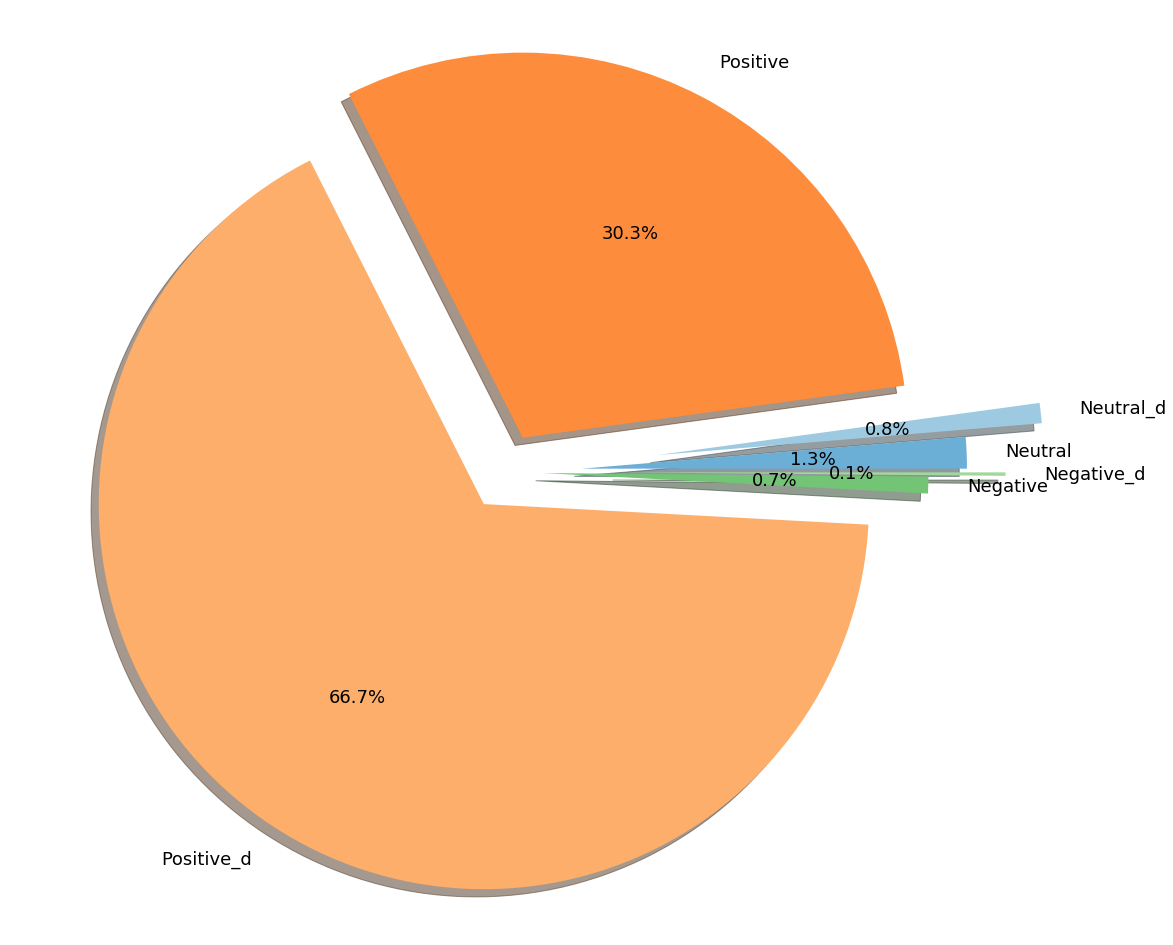

In [13]:
dups = np.subtract(lcs, nd_lcs)
all_cnts = np.array([[nd_lcs[0],dups[0]],[nd_lcs[1],dups[1]],[nd_lcs[2],dups[2]]])
all_lcp = all_cnts/np.sum(all_cnts)
labels = ['Neutral','Neutral_d','Positive','Positive_d','Negative','Negative_d']
cmap = plt.get_cmap("tab20c")
colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
f, ax = plt.subplots(1,1,figsize=(20,17))
explode = (0.2, 0.4, 0.1, 0.1, 0.1, 0.3)
ax.pie(all_cnts.flatten(), explode=explode, labels=labels, colors=colors, \
       autopct='%1.1f%%', shadow=True, textprops={'fontsize':18})
ax.axis('equal')

[None]

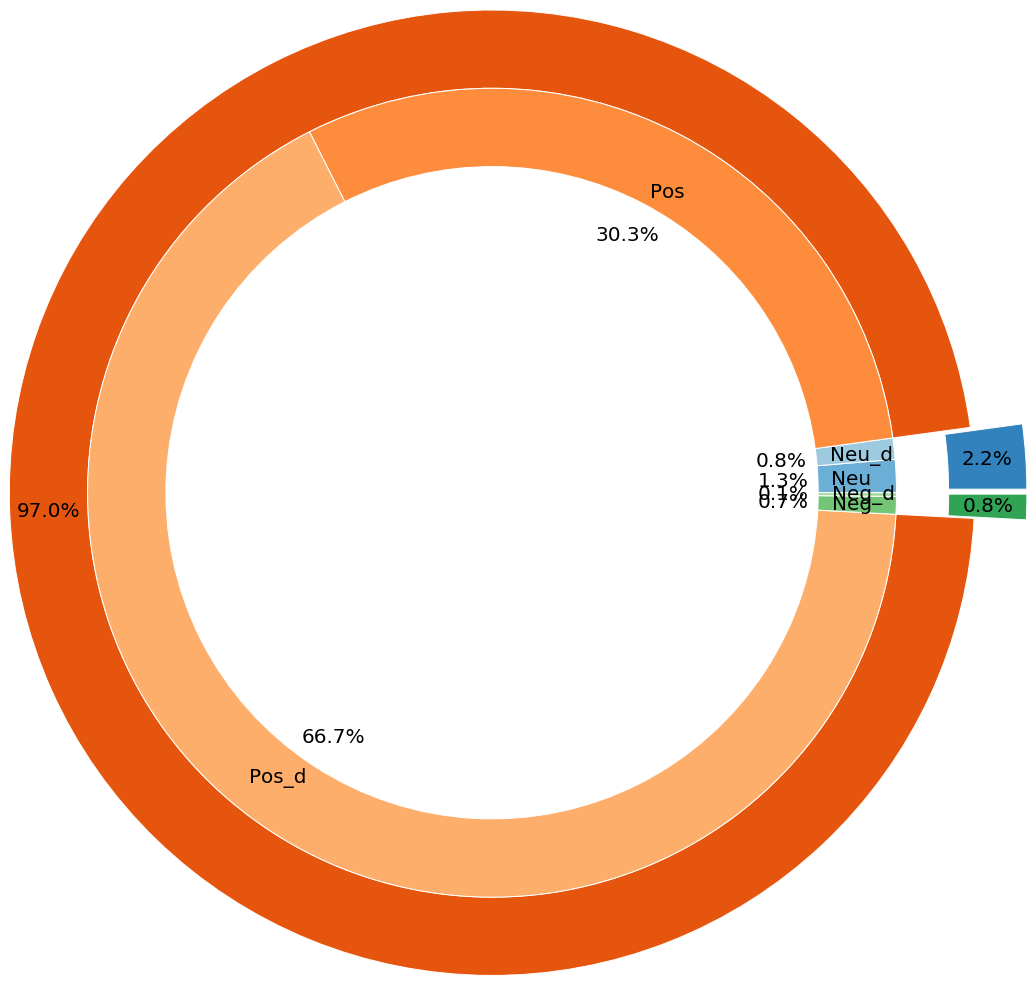

In [15]:
labels = ['Neu','Neu_d','Pos','Pos_d','Neg','Neg_d']
f, ax = plt.subplots(1,1,figsize=(12,12))

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
vals = all_cnts
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
oexplode = (0.2,0,0.2)
r = 1.85
ax.pie(vals.sum(axis=1), radius=r, colors=outer_colors,\
       wedgeprops=dict(width=size, edgecolor='w'), explode=oexplode,\
       pctdistance=0.92, autopct='%1.1f%%',textprops={'fontsize':20})

ax.pie(vals.flatten(), radius=r-size, colors=inner_colors,\
       labels=labels, wedgeprops=dict(width=size, edgecolor='w'),\
       labeldistance=0.84, pctdistance=0.72, autopct='%1.1f%%',textprops={'fontsize':20})

#Draw circle
#centre_circle = plt.Circle((0,0),1.24,color='white', fc='gray',linewidth=0)
#f = plt.gcf()
#f.gca().add_artist(centre_circle)
 
#ax.axis('equal')
#f.tight_layout()
ax.set(aspect="equal")#, title='Pie plot with `ax.pie`')

In [16]:
pos_comments = yhat_no_dup[yhat_no_dup.pred_sentiment==1]
neg_comments = yhat_no_dup[yhat_no_dup.pred_sentiment==2]
neu_comments = yhat_no_dup[yhat_no_dup.pred_sentiment==0]

In [17]:
neg_comments[neg_comments['2_prob']<=0.9].iloc[:1000].to_csv('/contents/output/csv/neg_comments_v1.csv', index=False, header=False)

In [18]:
neg = " ".join(c for c in neg_comments['text'])
pos = " ".join(c for c in pos_comments['text'])

In [23]:
stopwords = ['xbos', 'xfld', '\n', 'and', 'of', 'the', 'in', 'or',\
             'Comment', 'my', 'this', 'Your', 'there', 'by', 'if', 'Write',\
            'are', 'to', 'but', 'that', 'they', 'it', 'Here', 'is', 'at', 'where',\
            'because', 'we', 'has', 'some', 'so', 'also', 'been', 'get', 'as',\
            'an', 'these', 'National', 'Monument','with', 'Ryan', 'Zinke',\
            'Secretary', 'area', 'for', 'have', 'would', 'be']
neg_wordcloud = WordCloud(max_words=150, min_font_size=7, stopwords=stopwords).generate(neg)
pos_wordcloud = WordCloud(max_words=150, min_font_size=7, stopwords=stopwords).generate(pos)

(-0.5, 399.5, 199.5, -0.5)

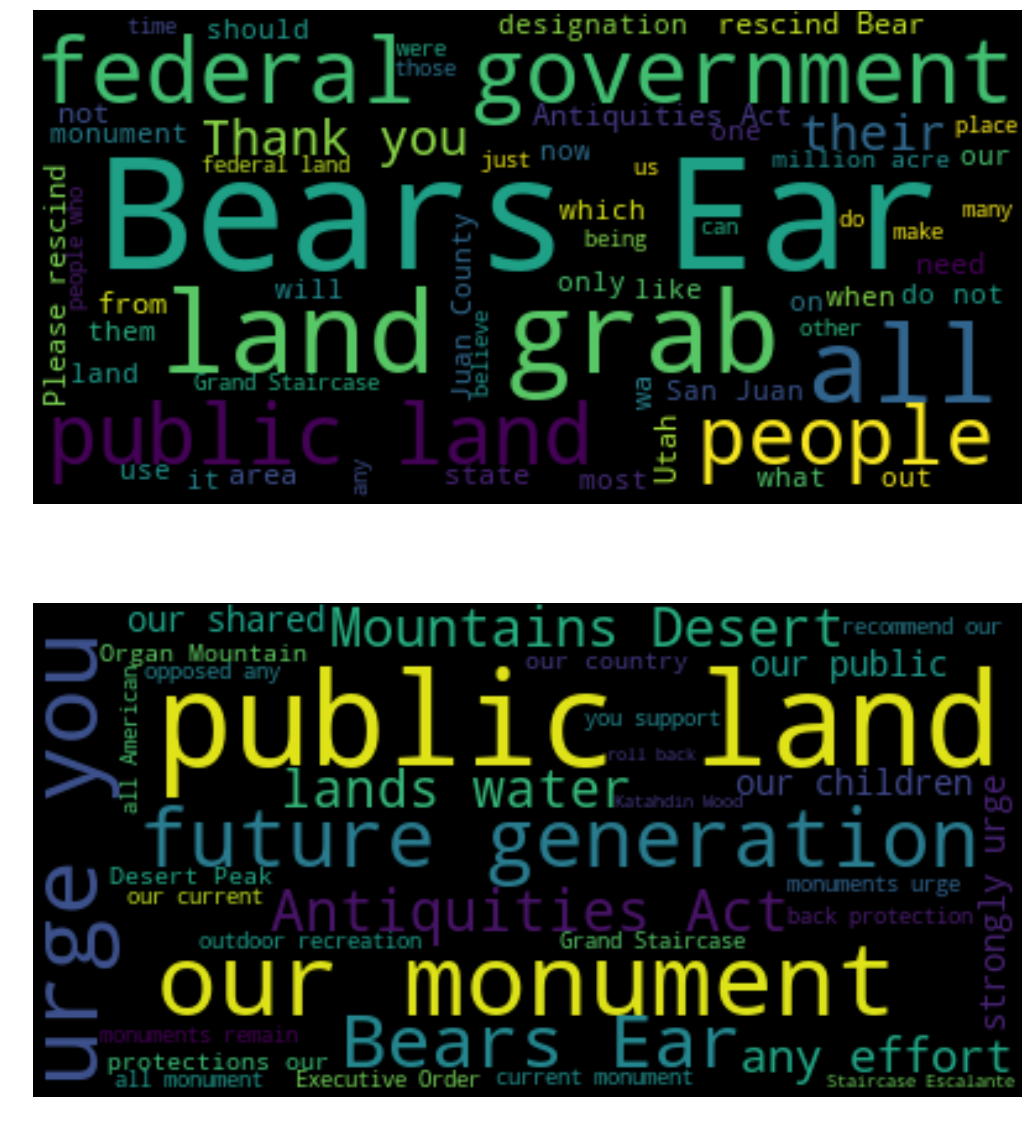

In [24]:
f, ax = plt.subplots(2,1,figsize=(20,20))
ax[0].imshow(neg_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[1].imshow(pos_wordcloud, interpolation='bilinear')
ax[1].axis('off')